# Mirco's Sex Dungeon
## Trovare l'algoritmo
Abbiano iniziato a pensare come poter esplorare un labirinto, e abbiamo deciso di usare un algoritmo di esplorazione per grafi: la BFS.
Subito ci siamo accorti che per poterla utilizzare era necessario conoscere l'intero layout del labirinto per tradurlo in un grafo quindi abbiamo riadattato l'algoritmo alle nostre esigenze.


In [ ]:
# Struttuta della cella del labiritno
class Cella:
    def __init__(self, init_str):
        cols = {82: "red", 66: "blue", 71: "green", 32: "white"}

        self.x = init_str['userX']
        self.y = init_str['userY']
        self.color = cols[init_str['userVal']]

    def __repr__(self) -> str:
        str_ = f"x: {self.x}\ty: {self.y}\tcolor: {self.color}"

        return str_

    def to_csv(self) -> str:
        str_ = f"{self.x},{self.y},{self.color}\n"
        return str_


L'algoritmo si basa sul fatto che ogni cella ha una propria X ed una propria Y da questa informazione è possibile creare una struttura dati contenente la lista di celle visitate in precedenza.

In [ ]:
# Analizza l'intero grafo, se invocata con True permette di analizzarne un secondo
def bfs_search(confronto=False):
    inizio = True
    while len(cammino) != 0 or inizio:
        inizio = False

        obj_cell = json.loads(mazeClient.send_command(command.GET_STATE))
        cell_attuale = Cella(obj_cell)

        # Controlla se la cella è già stata visitata, in caso la aggiunge alla coda visitate
        to_append = False
        for cell in visitate:
            if cell.x == cell_attuale.x and cell.y == cell_attuale.y:
                to_append = True

        if not to_append:
            visitate.append(cell_attuale)
        #-----------------------------------------------------------------------------------#

        # Se la cella non ha vicini da visitare inizia il traceback
        if not movimento(cell_attuale, remove_usless_neigh(cell_attuale, obj_cell['Neighbors'])):
            test = traceback()
            
            # Se il traceback ritorna True la cella ha vicini non visitati, quindi ricomincio ad esplorare
            if test:
                new_cell = json.loads(mazeClient.send_command(command.GET_STATE))
                tmp = Cella(new_cell)

                # Se movimento ritorna False, non ci sono più celle da visitare
                if not movimento(tmp, remove_usless_neigh(tmp, new_cell['Neighbors'])):
                    break
    
    # Creo i csv
    print("Esporto i dati in CSV ...")
    if confronto:
        create_csv("data2.csv")
    else:
        create_csv("data.csv")

    visitate.clear()
    cammino.clear()

    print("FATTO !\n")


In oltre, poichè gli unici movimenti possibili sono Destra, Sinistra, Su e Giù, e le celle considerate vicine comprendono anche le celle posizionate diagonalmente, è stato necessario eliminare le suddette dalla lista dei vicini.

In [ ]:
# Toglie le celle adiacenti (vicini) diagonali alla cella passata
def remove_usless_neigh(me: Cella, vicini: dict) -> list:
    cont = 0

    tmp = vicini.copy()

    for elem in vicini:
        if elem['x'] != me.x:
            if elem['y'] != me.y:
                del tmp[cont]
                cont -= 1
        cont += 1
    return tmp


Tramite la seguente funzione abbiamo fatto capire all'algoritmo come muoversi nel labirinto:

In [ ]:
# Capisce come muoversi tra le celle vicine, e aggiunge il movimento fatto e l'inverso alla coda
def movimento(cella_attuale: Cella, vicini: list) -> bool:
    for neigh in vicini:
        # Controlla se c'è un vicino non visitato
        trovato = False
        for cell in visitate:
            if (neigh['x'] == cell.x and neigh['y'] == cell.y):
                trovato = True
        #---------------------------------------#

        if not trovato:
            if cella_attuale.y < neigh['y'] and cella_attuale.x == neigh['x']:
                mazeClient.send_command(command.MOVE_LEFT)
                cammino.append((command.MOVE_LEFT, command.MOVE_RIGHT))

            elif cella_attuale.y > neigh['y'] and cella_attuale.x == neigh['x']:
                mazeClient.send_command(command.MOVE_RIGHT)
                cammino.append((command.MOVE_RIGHT, command.MOVE_LEFT))

            elif cella_attuale.y == neigh['y'] and cella_attuale.x < neigh['x']:
                mazeClient.send_command(command.MOVE_UP)
                cammino.append((command.MOVE_UP, command.MOVE_DOWN))

            elif cella_attuale.y == neigh['y'] and cella_attuale.x > neigh['x']:
                mazeClient.send_command(command.MOVE_DOWN)
                cammino.append((command.MOVE_DOWN, command.MOVE_UP))

            return True     # Si è mosso
    return False            # Non ha trovato vicini validi, inizio traceback


L'algoritmo inizia con la visita di un vicino della cella di partenza, ad ogni movimento salva in una lista il movimento eseguito, così da ricordarsi il percorso da fare durante il traceback, che si interrompe quando si incontra una cella avente un vicino non visitato.
Questo processo si ripete fino a che la cella iniziale non ha più vicini da visitare, terminando dunque sempre nella posizione di partenza.

In [ ]:
# Tornando indietro controllo se ci sono vicini non visitati
def traceback() -> bool:
    while True:
        # Se 0 sono tornato alla cella di inizio
        if len(cammino) == 0:
            return False    # Algoritmo finito

        cmd = cammino.pop()
        mazeClient.send_command(cmd[1])

        me = json.loads(mazeClient.send_command(command.GET_STATE))
        vicini = remove_usless_neigh(Cella(me), me['Neighbors'])

        for neigh in vicini:
            trovato = False

            # Controlla se c'è un vicino non visitato
            for cell in visitate:
                if (neigh['x'] == cell.x and neigh['y'] == cell.y):
                    trovato = True

            if not trovato:
                return True # La cella dove sono tornato ha ancora vicini da visitare



Alla fine i dati (x, y, color) delle relative celle vengono scritti in un file csv.

In [ ]:
# Creazione file csv con nome passatogli
def create_csv(nome: str):
    with open(nome, 'w') as myfile:
        myfile.write("x,y,color\n")
        for elem in visitate:
            myfile.write(elem.to_csv())

## Stampa della mappa
Per la stampa della mappa del labirinto abbiamo usato una matrice che poi viene rempita con i nostri dati e poi stampata a schermo tramite terminale.

La matrice è specchiata per avere la stessa visualizzazione che si ha nel mazeEngine.

In [ ]:
# Creazione e modifica della matrice prima della stampa a video
def plot_maze():
    init(autoreset=True)    # Server per l'output colorato

    data = load_data('data.csv')

    max_x = data['x'].max()
    max_y = data['y'].max()

    massimo = max(max_y, max_x)

    matrice = np.zeros((massimo, massimo), dtype=int)

    # Sistema le coordinate nella matrice
    for _, row in data.iterrows():
        matrice[- int(row['x']) % massimo][- int(row['y']) % massimo] = dict_colori2[row['color']]

    print_matrix(matrice)
    print("\nLa mappa è orientata come nel MazeEngine.\nLa riga delle X inizia dal basso verso l'alto.\nLa riga delle Y parte da destra a sinitra nelle verticali.\n")    


Questa funzione serve per distinguere e rappresentare i vari colori a video.

In [ ]:
# Stampa a video della Mappa
def print_matrix(matrice: np.ndarray):
    str_ = ""
    for i in range(len(matrice)):
        for j in range(len(matrice)):
            if matrice[i][j] == 0:
                str_ += Back.BLACK + "  "
            elif matrice[i][j] == 1:
                str_ += Back.WHITE + "  "
            elif matrice[i][j] == 2:
                str_ += Back.RED + "  "
            elif matrice[i][j] == 3:
                str_ += Back.BLUE + "  "
            elif matrice[i][j] == 4:
                str_ += Back.GREEN + "  "

        str_ += Back.BLACK + "\n"
    print(str_)


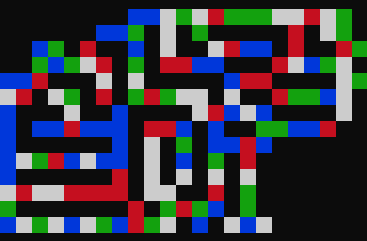

## Data Analysis
Per lo svolgimento del data analysis abbiamo usato pandas, che ci ha permesso di manipolare il file csv creato in precedenza per estrarre il numero di celle relative ad un certo colore in corrispondenza delle cordinate x e y.
Successivamente abbiamo stampato a video, tramite matplotlib, i grafici relativi alle due coordinate.

In [ ]:
# Stampa il dataframe passatogli come istogramma
def plot_coordinata(data: pd.DataFrame, coordinata: str, alpha_value=1.0, title="Grafico 1"):

    data = data[[coordinata,'color']]

    rosse = data[data['color'] == 'red'].groupby(coordinata).count()
    blu = data[data['color'] == 'blue'].groupby(coordinata).count()
    verdi = data[data['color'] == 'green'].groupby(coordinata).count()

    ax = pd.concat([rosse,verdi,blu], axis = 1).plot(kind = 'bar', color = ['r','g','b'])
    ax.legend(["R", "G", "B"])
    ax.set_title(title)


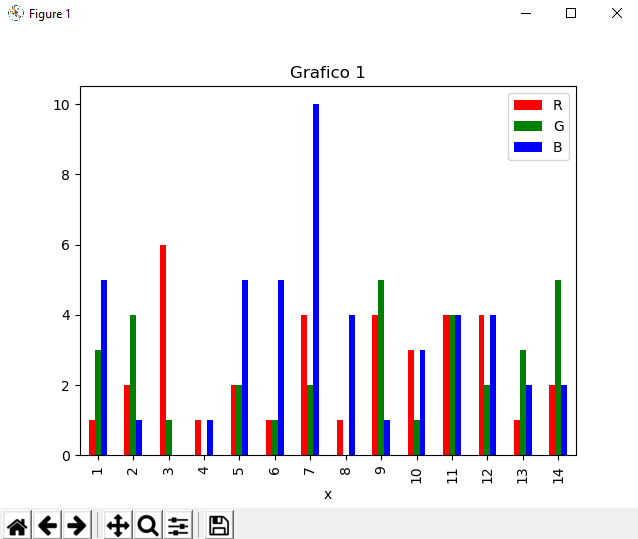
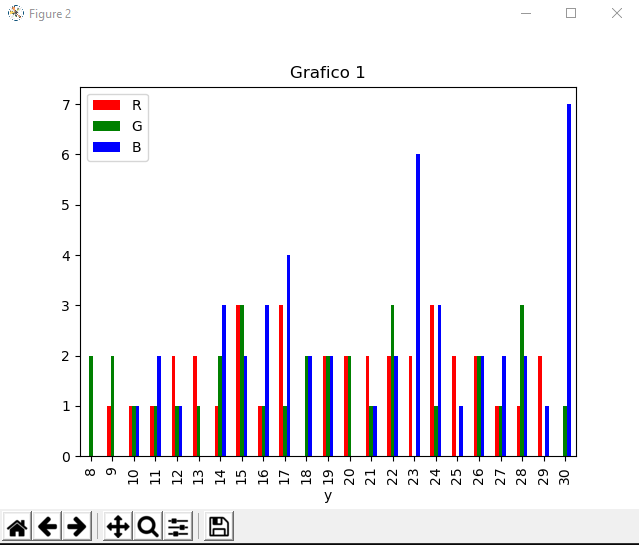

Con pandas abbiamo anche ricavato il numero totale di celle e soltanto quelle Rosse, Verdi e Blu.

In [ ]:
# Conta il totale delle celle e il colore
def cell_stats(data: pd.DataFrame):
    colors = data['color'].value_counts()
    
    print(f"\nIl totale delle celle nel labirinto è di {data['color'].count()}.\n")
    
    # Tolgo le celle bianche
    colors.drop('white', inplace=True)
    
    for color, value in colors.iteritems():
        print(f"{color}:\t{value}")


### Confronto di due Labirinti
Per la quest avanzata di visitare e confrontare due labirinti differenti abbiamo semplicemente fatto partire l'algoritmo su due labiritni diversi ricordandoci di eliminare il seed vecchio e far riavviare il mazeEngine.

In [ ]:
# Genera 2 grafici e li confronta 
def confronto():
    bfs_search()
    mazeClient.send_command(command.EXIT)

    controls.del_seed()
    controls.open_maze()
    
    sleep(0.5)
    
    bfs_search(confronto=True)
    mazeClient.send_command(command.EXIT)

    plot_stats(confronto=True)  # Stampa i grafici


## Libera Esplorazione
Attraverso la seguente funzione viene gestito il movimento libero per il labirinto, utilizzabile con l'argomento --free_move nel main.

In [ ]:
# Capice quale comando mandare al server usando freccie direzionali come input
def move(input: str) -> str:
    option = {
        "H": command.MOVE_UP,
        "P": command.MOVE_DOWN,
        "M": command.MOVE_RIGHT,
        "K": command.MOVE_LEFT
    }

    return mazeClient.send_command(option[input])


# Permette di muoversi liberamente nel labirinto
def free_move():
    fine = False
    print("Per muoversi usare le freccie direzionali.\nPer uscire digitare q.")
    while not fine:
        # Controllo del caratere inserito
        escape = getch.getch()  # Prende il primo carattere delle freccie direzionali
        if escape != b'\x00':
            if escape == b'q':
                fine = True
                continue

            print("Carattere invalido !")
            continue

        char_ = getch.getch()   # Prende il secondo carattere delle freccie direzionali 

        move(char_.decode("ascii"))


## Altro:
Abbiamo anche aggiunto nella main la possibilità di poter visitare il labirinto senza una mappa con l'argomento --free_move e invece la possibilità di visitarlo dopo averne stampato la mappa con --move_map.
Oltre a questo abbiamo inserito il file `requirements.txt` nel quale ci sono le dipendenze.

# Il team:
* __Nicolò "Eugenio" Vescera__, @ncvescera su GitHub
* __Tommaso "Gay" Romani__
* __Nicolò "Brüno" Posta__

